# Deep Learning Models with SMOTE for Korean Vishing Detection

In [1]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2024-02-15 12:58:49.577521: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-15 12:58:49.681851: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 12:58:49.681909: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 12:58:49.683612: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 12:58:49.691221: I tensorflow/core/platform/cpu_feature_guar

# Import library

In [2]:
from time import time
from timeit import default_timer as timer
from datetime import timedelta, datetime
import re
import os
import io
import pickle
import sys
import subprocess
from glob import glob
import csv
import math
import codecs
import copy
from tqdm import tqdm

# EDA
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
from wordcloud import WordCloud
from collections import Counter
import numpy as np
import pandas as pd

# NLP & ML 
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix, 
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    fbeta_score,
    roc_auc_score,
    matthews_corrcoef,
    cohen_kappa_score
)

# DL
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    InputSpec,
    Layer, 
    Input,
    Embedding, 
    Conv1D, 
    Conv2D, 
    Bidirectional, 
    Dense, 
    Attention,
    LSTM, 
    Activation, 
    Add, 
    Flatten, 
    Concatenate, 
    concatenate,
    Reshape, 
    Dropout, 
    SpatialDropout1D, 
    BatchNormalization,
    MaxPooling1D, 
    MaxPool2D, 
    GlobalAveragePooling1D, 
    GlobalMaxPooling1D, 
    GlobalMaxPool1D
)
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# SMOTE
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

2024-02-15 12:58:54.561369: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-15 12:58:54.585424: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 12:58:54.585457: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 12:58:54.586250: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 12:58:54.591038: I tensorflow/core/platform/cpu_feature_guar

# Plotting code

In [3]:
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
#     from itertools import izip
    pc.update_scalarmappable()
    ax = pc.axes# FOR LATEST MATPLOTLIB
    
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        # ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      
    
    # save the figure
    plt.savefig('reports/' + title + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
    plt.savefig('reports/' + title + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))
    

#
def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)
    
# Function to plot the training and validation loss and accuracy
def plot_loss_accuracy(history, model_name):
    # plot the training and validation loss
    plt.plot(history.epoch, history.history['loss'], '-o', label='Training_loss')
    plt.plot(history.epoch, history.history['val_loss'], '-o', label='Validation_loss')
    plt.title(model_name + ' model loss')
    plt.grid(True)
    plt.legend()
    plt.xlim(left=0)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig('reports/' + model_name + '_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
    plt.savefig('reports/' + model_name + '_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()
    
    # plot the training and validation accuracy
    plt.plot(history.epoch, history.history['accuracy'], '-o', label='Training_accuracy')
    plt.plot(history.epoch, history.history['val_accuracy'], '-o', label='Validation_accuracy')
    plt.title(model_name + ' model accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlim(left=0)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.savefig('reports/' + model_name + '_accuracy' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
    plt.savefig('reports/' + model_name + '_accuracy' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()

def plot_class_distribution(data, title):
    sns.set(style="whitegrid")
    # sns.set(style="ticks")
    ax = sns.countplot(x='label', data=data)
    ax.set_title(title)
    
    # Annotate the bars with the number of samples
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
        
    plt.show()

# Function to plot the distribution of the length of the data samples in the train_set, val_set and test_set (boxplot and histogram)
def plot_length_distribution(data, title):
    sns.set(style="whitegrid")
    # sns.set(style="ticks")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(title)
    
    # plot the boxplot
    # sns.boxplot(x='length', data=data, ax=ax1)
    sns.boxplot(y='length', x='label', data=data, ax=ax1)
    ax1.set_title('Boxplot')
    
    # plot the histogram
    sns.histplot(x='length', data=data, ax=ax2)
    ax2.set_title('Histogram')
    
    plt.show()

# Data Preprocessing

## Vectorization of the datasets
Encoding the text data into numerical data for the deep learning models

In [4]:
#load the datasets
print('Loading datasets...')
train_set= pd.read_csv('datasets/train_set_ready.csv')
val_set = pd.read_csv('datasets/val_set_ready.csv')
test_set = pd.read_csv('datasets/test_set_ready.csv')

print('Datasets loaded.')

Loading datasets...
Datasets loaded.


In [5]:
train_set.columns = train_set.columns.str.strip()
print("Original length of df:", len(train_set))
train_set.replace([np.inf, -np.inf], np.nan, inplace=True)
train_set.dropna(inplace=True)
print("After droping null values, the length of df:", len(train_set))

Original length of df: 2047
After droping null values, the length of df: 2047


In [6]:
train_set.label.value_counts()

label
0    1562
1     485
Name: count, dtype: int64

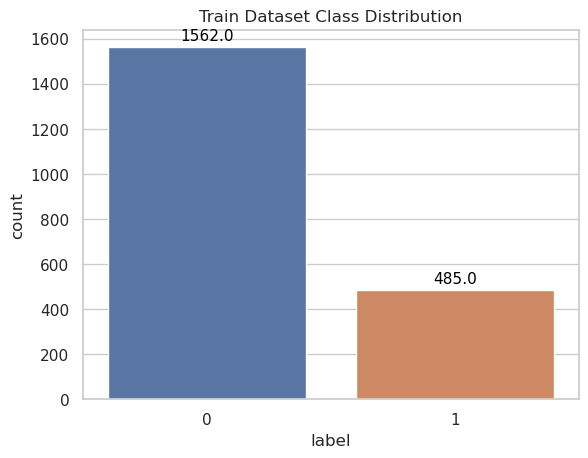

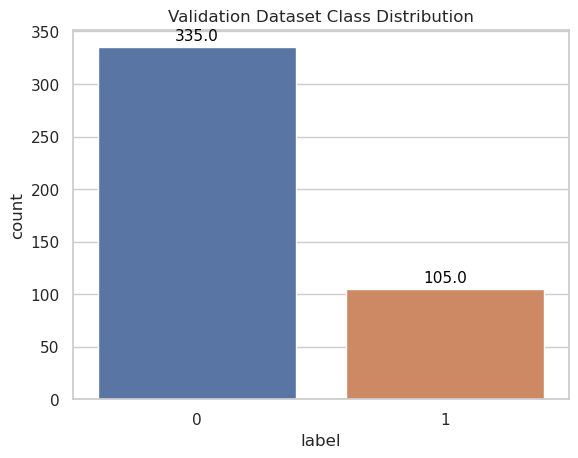

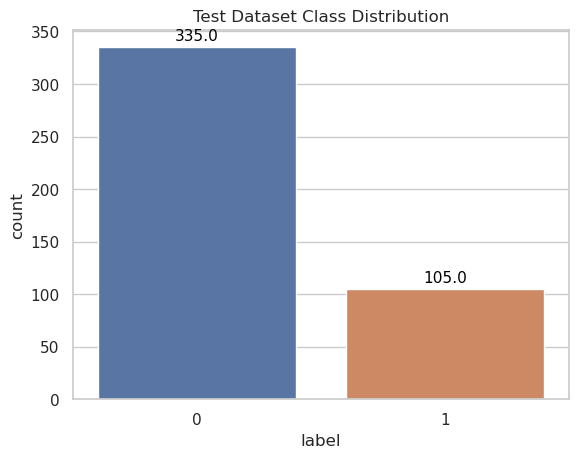

In [7]:
plot_class_distribution(train_set, 'Train Dataset Class Distribution')
plot_class_distribution(val_set, 'Validation Dataset Class Distribution')
plot_class_distribution(test_set, 'Test Dataset Class Distribution')

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


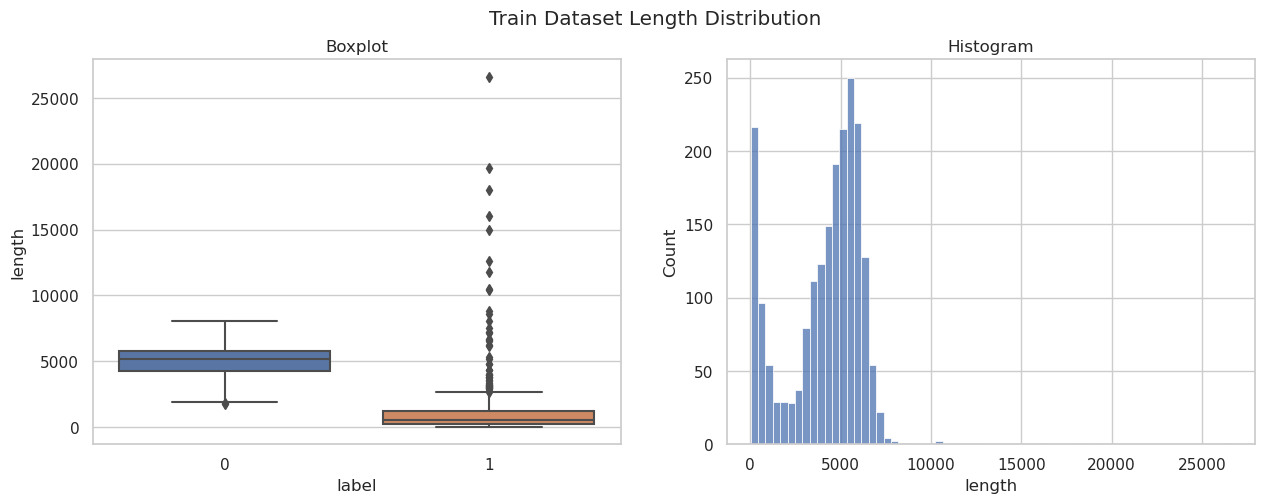

In [8]:
plot_length_distribution(train_set, 'Train Dataset Length Distribution')

In [9]:
# define the train and test sets data from the dataframes
X_train = train_set['corpus']
X_train_1 = train_set['corpus_1']
y_train = train_set['label']

X_val = val_set['corpus']
X_val_1 = val_set['corpus_1']
y_val = val_set['label']

X_test = test_set['corpus']
X_test_1 = test_set['corpus_1']
y_test = test_set['label']

In [10]:
# Function to define the maximum number of words to be used
def max_words_func(X_train, X_val, X_test):
    max_len = 0
    max_words = 0
 
    # check the length of the trainset, the valset and the testset
    print('Train set size = {} \nValidation set size = {} \nTest set size = {}'.format(len(X_train), len(X_val), len(X_test)))
    
    # count the maximum number of words in the trainset
    max_words = len(set(" ".join(X_train).split())) # max number of words for tokenizer
    print('Maximum number of words in the train set = {}'.format(max_words))
    
    # get the maximum length of the sentences in the trainset
    max_len = max([len(x.split()) for x in X_train]) # max length of each sentences, including padding
    print('Maximum length of a sentence in the train set = {}'.format(max_len))

    return max_words, max_len

In [11]:
# define the maximum number of words and the maximum length of the sentences in the trainset
max_words, max_len = max_words_func(X_train, X_val, X_test)

Train set size = 2047 
Validation set size = 440 
Test set size = 440
Maximum number of words in the train set = 33844
Maximum length of a sentence in the train set = 4715


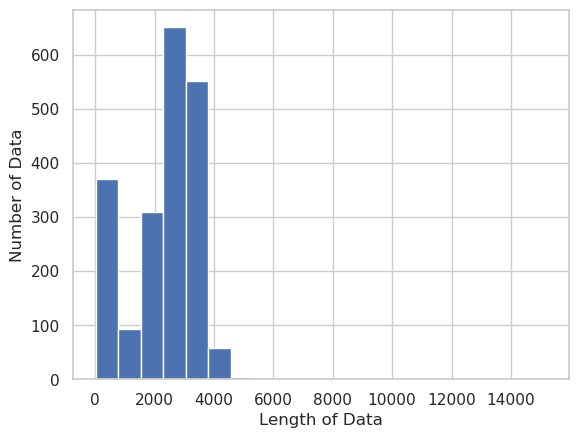

In [12]:
plt.hist([len(s) for s in X_train], bins=20)
plt.xlabel('Length of Data')
plt.ylabel('Number of Data')
plt.show()

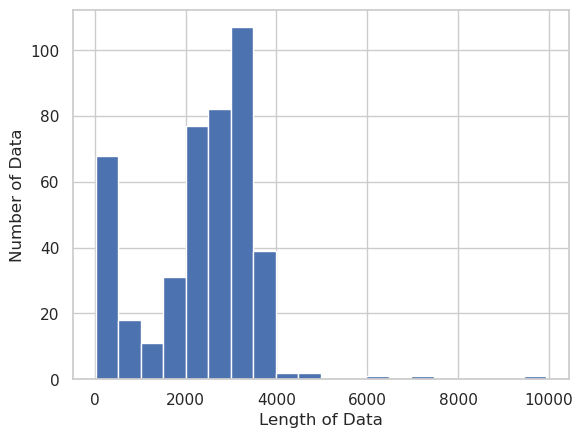

In [13]:
plt.hist([len(s) for s in X_test], bins=20)
plt.xlabel('Length of Data')
plt.ylabel('Number of Data')
plt.show()

### Training with the original train_set dataset

In [14]:
# Function to tokenize the text data
def tokenize_text(X_train, X_val, X_test, max_words=max_words, max_len=max_len):
    # define the tokenizer and tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=False, char_level=False)
    tokenizer.fit_on_texts(X_train)  #leaky
    
    # Function to convert texts to sequences of integers
    def texts_to_sequences(X_train, X_val, X_test):
        # convert texts to sequences of integers
        X_train_seq = tokenizer.texts_to_sequences(X_train)
        X_val_seq = tokenizer.texts_to_sequences(X_val)
        X_test_seq = tokenizer.texts_to_sequences(X_test)
        word_index = tokenizer.word_index
        
        print("Dictionary size: ", len(word_index))
        
        return X_train_seq, X_val_seq, X_test_seq, word_index
    
    # define the sequences of integers
    X_train_seq, X_val_seq, X_test_seq, word_index = texts_to_sequences(X_train, X_val, X_test)
    
    # FPad the sequences to ensure uniform length
    X_train_pad = pad_sequences(X_train_seq, padding='pre', maxlen=max_len)
    X_val_pad = pad_sequences(X_val_seq, padding='pre', maxlen=max_len)
    X_test_pad = pad_sequences(X_test_seq, padding='pre', maxlen=max_len)
    
    return X_train_pad, X_val_pad, X_test_pad, word_index

In [15]:
# tokenize the text data
X_train_pad, X_val_pad, X_test_pad, word_index = tokenize_text(X_train, X_val, X_test, max_words, max_len)

Dictionary size:  33844


### Applying SMOTE methods to balance the training set dataset

In [16]:
# Function to balance the training dataset according to the selected SMOTE methods
def balance_trainset(X_train, y_train, method='SMOTE'):
    #name for oversampling method
    over_name = ''
    
    # define the SMOTE method
    if method == 'SMOTE':
        smote = SMOTE(random_state=42)
        over_name = smote.__class__.__name__
    elif method == 'ADASYN':
        smote = ADASYN(random_state=42)
        over_name = smote.__class__.__name__
    elif method == 'SMOTEENN':
        smote = SMOTEENN(random_state=42)
        over_name = smote.__class__.__name__
    elif method == 'SMOTETomek':
        smote = SMOTETomek(random_state=42)
        over_name = smote.__class__.__name__
    elif method == 'SVMSMOTE':
        smote = SVMSMOTE(random_state=42)
        over_name = smote.__class__.__name__
    elif method == 'KMeansSMOTE':
        smote = KMeansSMOTE(random_state=42)
        over_name = smote.__class__.__name__
    elif method == 'BorderlineSMOTE':
        smote = BorderlineSMOTE(random_state=42)
        over_name = smote.__class__.__name__
    else:
        smote = SMOTE(random_state=42)
        over_name = smote.__class__.__name__
    
    # Dataset shape
    print("-- Dataset shape --")
    print('Original dataset shape')
    print(Counter(y_train),'\n')#Counting the samples in training set
        
    # resampling/fit the SMOTE model to the trainset
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    print(over_name)
    print('Resampled training set shape %s' % Counter(y_train_res))
    
    return X_train_res, y_train_res, over_name

In [17]:
# select the SMOTE method to balance the training dataset
smote_method = 'SMOTE'
X_train_res, y_train_res, over_name = balance_trainset(X_train_pad, y_train, smote_method)

-- Dataset shape --
Original dataset shape
Counter({0: 1562, 1: 485}) 

SMOTE
Resampled training set shape Counter({0: 1562, 1: 1562})


# Model Building and Training

## Importing the FastText word embeddings

In [18]:
# run if the wiki.ko.vec is not available in the same directory
import os
import urllib.request
# check if the file wiki.ko.vec is in the directory if not download it
if not os.path.isfile('wiki.ko.vec'):
    print('wiki.ko.vec does not exist, downloading file from the internet')
    # download the FastText word embeddings and monitor the download progress bar with tqdm
    with tqdm(unit='B', unit_scale=True, miniters=1, desc='wiki.ko.vec') as t:
        urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ko.vec', 'wiki.ko.vec', reporthook=lambda a,b,c: t.update(c))
    # urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ko.vec', 'wiki.ko.vec')
else:
    print('wiki.ko.vec exists, will not download file from the internet')

wiki.ko.vec exists, will not download file from the internet


In [19]:
# import the FastText word embeddings
print('Loading word FastText embeddings...')
embeddings_index = {}
f = codecs.open('wiki.ko.vec', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

Loading word FastText embeddings...


879131it [15:13, 962.51it/s] 


In [20]:
print('Found %s word vectors' % len(embeddings_index))

Found 879130 word vectors


In [21]:
# define the preprocessing parameters
embedding_dim = 300 # embedding dimensions for word vectors (word2vec/GloVe/Fasttext)

# defining the hyperparameters
learning_rate = 1e-3
batch_size= 32 # 64, 128
epochs = 10
steps_per_epoch = len(X_train) // batch_size  # total_samples is the training set size

# Calculating decay steps
# It's common to decay the learning rate at each epoch
decay_steps = steps_per_epoch * epochs # 10000
decay_rate = 0.9  # This is a common decay rate, but you can adjust it
# learning_decay = 1e-10 # 1e-4

spa_dropout_ratio = 0.2 # dropout ration, dropping a entire feature map
kernel_size = 3 # [1,2,3,5] # [1,2,3,5] Size of the kernel. Mixing kernels of various sizes.
                # specifying the length of the 1D convolution window.
dense_units = 64 # hidden unit 128 the number of neurons in the hidden layer
dropout_ratio = 0.2 # 0.1, 0.2 to 0.5 Dropout Ratio
num_filters = 50 # 36, 128, 256 number of kernels, conv_size
                # Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).

lstm_units_1 = 64 # the size(dim) of the hidden state vector as well as the output vector.
lstm_units_2 = 32 # the size(dim) of the hidden state vector as well as the output vector.

### Preparing FastText embedding matrix for future use

In [22]:
#embedding matrix
# print('Preparing embedding matrix for future use...')
words_not_found = []
embed_dim = embedding_dim #300 # 32 Dimensions of the embedding vector
nb_words = min(max_words, len(word_index))
embedding_matrix = np.zeros((max_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
print("sample words not found: ", np.random.choice(words_not_found, 10))

number of null word embeddings: 8636
sample words not found:  ['선자령' '다가온다고' '보따릴' '생새우' '언질' '건넜' '뚜들기' '도행' '찾아뵈' '꼬집']


In [23]:
# Setting up our results dataframe
df_results = pd.DataFrame(columns=['F1_score', 'Precision', 'Recall', 'Accuracy', 'Training time'])
df_results

,F1_score,Precision,Recall,Accuracy,Training time


## Training with default embedding layer and the SMOTE sampling method

### Single LSTM layer

In [24]:
# write a function to build, train and evaluate the LSTM model
def build_train_lstm_model(model_name, X_train, y_train, X_val, y_val, X_test, y_test, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, embedding_matrix=None):
    
    # define the model architecture
    model = Sequential()
    # check if the embedding_matrix is None or not
    if embedding_matrix is None:
        model.add(Embedding(max_words, embedding_dim, input_length=max_len, trainable=False))
    else:
        model.add(Embedding(max_words, embedding_dim, weights= [embedding_matrix], input_length=max_len, trainable=False))
    
    # model.add(SpatialDropout1D(spa_dropout_ratio))
    model.add(LSTM(lstm_units_1))
    model.add(Dense(dense_units, activation='relu'))
    # model.add(LSTM(lstm_units_1, dropout=dropout_ratio, recurrent_dropout=dropout_ratio))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification
    
    # compile the model
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate
    )
    
    model.compile(
        # optimizer=Adam(learning_rate=learning_rate, decay=learning_rate / decay_steps),
        optimizer = Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    # print the model summary
    print(model.summary())
    print('#' * 150)
    
    # Create a callback that saves the best model during validation
    model_checkpoint = ModelCheckpoint(
        "models/" + model_name + "_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        # "models/LSTM_"+ datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        monitor='val_accuracy', # val_loss or val_accuracy 
        verbose=1,
        save_best_only=True,
        mode='max' # max for val_accuracy, min for val_loss
    )
    # EarlyStopping to stop training when the validation loss has stopped improving
    early_stopping = EarlyStopping(
        monitor = 'val_loss',
        verbose = 1,
        patience = 3, # Number of epochs with no improvement after which training will be stopped.
        mode = 'min'
    )

    # TensorBoard for visualization
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # train the model
    start_time = time()
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=[model_checkpoint, early_stopping, tensorboard_callback]
    )
    end_time = time()
    training_time = end_time - start_time
    
    # print the training time
    print('Training time: {}'.format(training_time))
    
    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print('Test Loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(accuracy))
    
    # predict the test set
    # y_pred = model.predict(X_test)
    # y_pred = np.argmax(y_pred, axis=1)
    # y_test = np.argmax(y_test, axis=1)
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs >= 0.5).astype(int)  # Convert probabilities to binary (0 or 1)
    
    # print the precision, recall and f1-score
    model_precision = precision_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    model_f1_score = f1_score(y_test, y_pred)
    print('Precision: {}'.format(model_precision))
    print('Recall: {}'.format(model_recall))
    print('F1-score: {}'.format(model_f1_score))
        
    # print the classification report
    report = classification_report(y_test, y_pred, digits=4, target_names=['None_vishing', 'Vishing'])
    print(report)
    
    # print the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\n-- Confusion matrix --\n', cm)
    print('True Positives(TP) = ', cm[0,0])
    print('True Negatives(TN) = ', cm[1,1])
    print('False Positives(FP) = ', cm[0,1])
    print('False Negatives(FN) = ', cm[1,0])
    
    # save the previous confusion matrix in a file following the TP, TN, FP, FN order
    np.savetxt('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv', cm, delimiter=',', fmt='%d')
    
    # save the confusion matrix in a dataframe wih the following columns: TP, TN, FP, FN
    df_cm = pd.DataFrame(cm, columns=['None_vishing', 'Vishing'], index=['None_vishing', 'Vishing'])
    df_cm.to_csv('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv')
    
    # save the model
    # model.save('models/{}.h5'.format(model_name))
    
    # save the history
    with open('histories/{}.pkl'.format(model_name), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    # save the results
    df_results.loc[model_name] = [model_f1_score, model_precision, model_recall, accuracy, training_time]
    # df_results.loc[model_name] = [f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), accuracy, training_time]  
    
    # print the results
    # df_results
    
    return model, history, report

In [25]:
# build, train and evaluate the LSTM model
model_name = over_name + '_LSTM'
model_lstm, history_lstm, report_lstm = build_train_lstm_model(model_name, X_train_res, y_train_res, X_val_pad, y_val, X_test_pad, y_test)

2024-02-15 13:14:14.465502: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 13:14:14.581402: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 13:14:14.581479: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 13:14:14.590322: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 13:14:14.590391: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4715, 300)         10153200  
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10250865 (39.10 MB)
Trainable params: 97665 (381.50 KB)
Non-trainable params: 10153200 (38.73 MB)
_________________________________________________________________
None
#####

2024-02-15 13:14:17.587177: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-15 13:14:18.378078: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8fa85053b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-15 13:14:18.378118: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-02-15 13:14:18.406829: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1707970458.514790   14927 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


98/98 [==============================] - ETA: 0s - loss: 0.4871 - accuracy: 0.7791
Epoch 1: val_accuracy improved from -inf to 0.99545, saving model to models/SMOTE_LSTM_20240215_131415.h5


/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - 33s 316ms/step - loss: 0.4871 - accuracy: 0.7791 - val_loss: 0.1231 - val_accuracy: 0.9955
Epoch 2/10
98/98 [==============================] - ETA: 0s - loss: 0.2906 - accuracy: 0.9059
Epoch 2: val_accuracy did not improve from 0.99545
98/98 [==============================] - 23s 230ms/step - loss: 0.2906 - accuracy: 0.9059 - val_loss: 0.3950 - val_accuracy: 0.9091
Epoch 3/10
98/98 [==============================] - ETA: 0s - loss: 0.2755 - accuracy: 0.9104
Epoch 3: val_accuracy did not improve from 0.99545
98/98 [==============================] - 23s 239ms/step - loss: 0.2755 - accuracy: 0.9104 - val_loss: 0.1471 - val_accuracy: 0.9568
Epoch 4/10
98/98 [==============================] - ETA: 0s - loss: 0.1936 - accuracy: 0.9331
Epoch 4: val_accuracy did not improve from 0.99545
98/98 [==============================] - 25s 252ms/step - loss: 0.1936 - accuracy: 0.9331 - val_loss: 0.1056 - val_accuracy: 0.9750
Epoch 5/10
98/98 [===================

In [26]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
SMOTE_LSTM,0.967136,0.953704,0.980952,0.984091,224.577615


#### Plot the results

[0.994, 0.9851, 0.9895]
[0.9537, 0.981, 0.9671]
plotMat: [[0.994, 0.9851, 0.9895], [0.9537, 0.981, 0.9671]]
support: [335, 105]


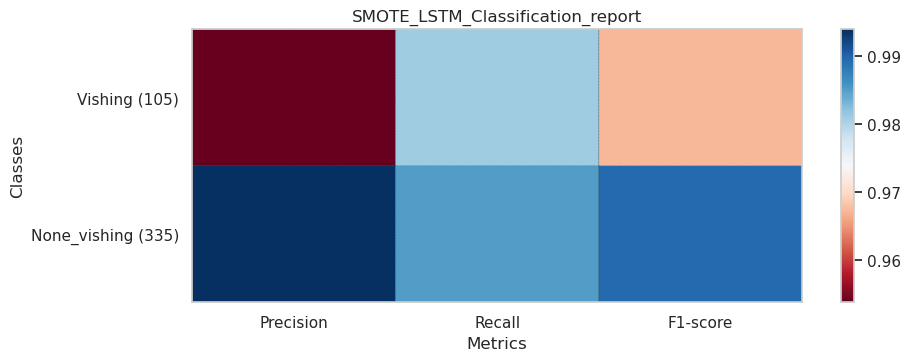

In [27]:
plot_name = over_name + '_LSTM_Classification_report'
plot_classification_report(report_lstm, plot_name)

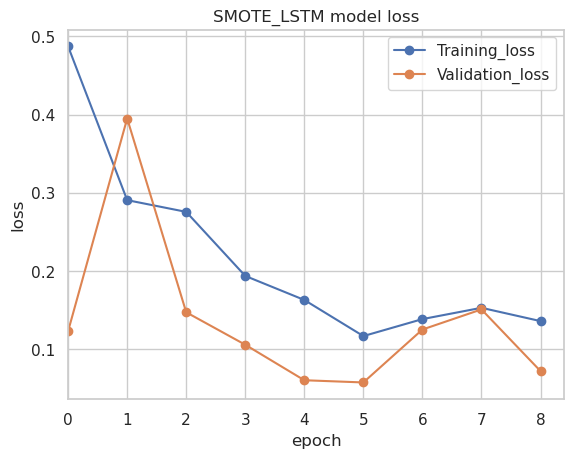

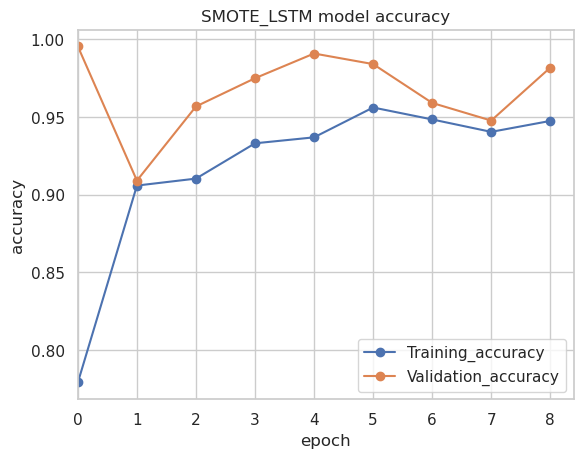

In [28]:
#plot the training and validation loss and accuracy
plot_name = over_name + '_LSTM'
plot_loss_accuracy(history_lstm, plot_name)

In [29]:
# plot the tensorboard results
# %load_ext tensorboard
# %tensorboard --logdir logs/fit
# %tensorboard --logdir logs/fit

### Single LSTM layer with FastText embedding layer

In [30]:
# build, train and evaluate the LSTM model
model_name = over_name + '_LSTM_FT'
model_lstm_ft, history_lstm_ft, report_lstm_ft = build_train_lstm_model(model_name, X_train_res, y_train_res, X_val_pad, y_val, X_test_pad, y_test, embedding_matrix=embedding_matrix)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 4715, 300)         10153200  
                                                                 
 lstm_1 (LSTM)               (None, 64)                93440     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10250865 (39.10 MB)
Trainable params: 97665 (381.50 KB)
Non-trainable params: 10153200 (38.73 MB)
_________________________________________________________________
None
###

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - 31s 256ms/step - loss: 0.4393 - accuracy: 0.8025 - val_loss: 0.1685 - val_accuracy: 0.9432
Epoch 2/10
98/98 [==============================] - ETA: 0s - loss: 0.2898 - accuracy: 0.8809
Epoch 2: val_accuracy did not improve from 0.94318
98/98 [==============================] - 22s 228ms/step - loss: 0.2898 - accuracy: 0.8809 - val_loss: 0.2011 - val_accuracy: 0.9341
Epoch 3/10
98/98 [==============================] - ETA: 0s - loss: 0.2140 - accuracy: 0.9097
Epoch 3: val_accuracy improved from 0.94318 to 0.97500, saving model to models/SMOTE_LSTM_FT_20240215_131807.h5
98/98 [==============================] - 25s 252ms/step - loss: 0.2140 - accuracy: 0.9097 - val_loss: 0.0672 - val_accuracy: 0.9750
Epoch 4/10
98/98 [==============================] - ETA: 0s - loss: 0.1856 - accuracy: 0.9257
Epoch 4: val_accuracy did not improve from 0.97500
98/98 [==============================] - 23s 234ms/step - loss: 0.1856 - accuracy: 0.9257 - val_loss: 0.4256

In [31]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
SMOTE_LSTM,0.967136,0.953704,0.980952,0.984091,224.577615
SMOTE_LSTM_FT,0.933333,0.875000,1.000000,0.965909,150.270501


[1.0, 0.9552, 0.9771]
[0.875, 1.0, 0.9333]
plotMat: [[1.0, 0.9552, 0.9771], [0.875, 1.0, 0.9333]]
support: [335, 105]


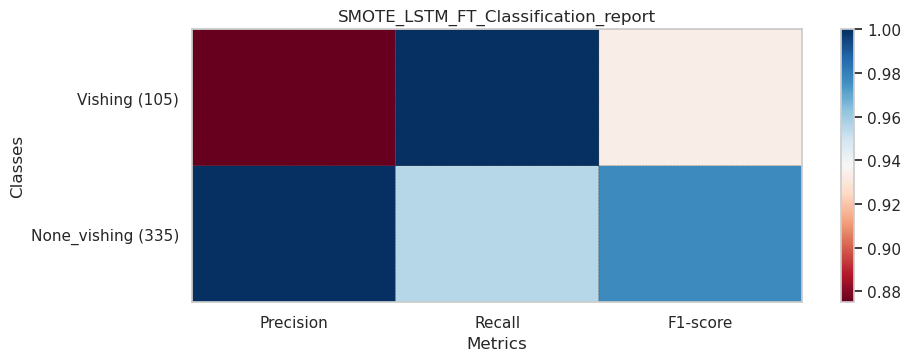

In [32]:
plot_name = over_name + '_LSTM_FT_Classification_report'
plot_classification_report(report_lstm_ft, plot_name)

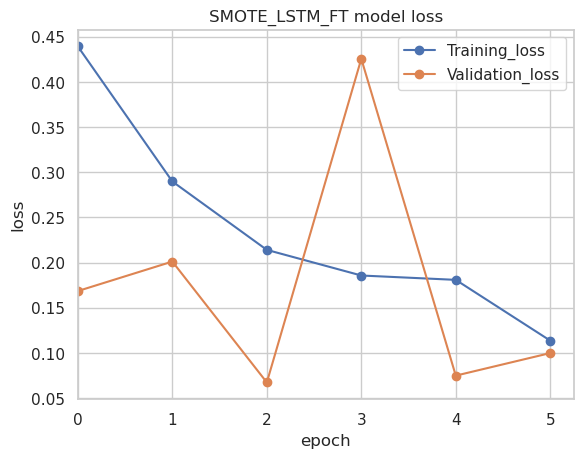

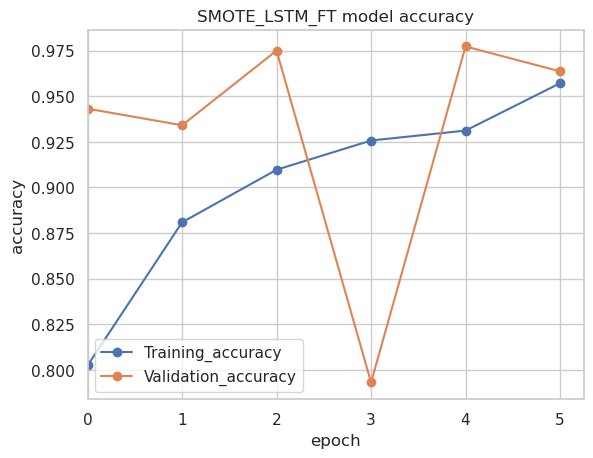

In [33]:
#plot the training and validation loss and accuracy
plot_name = over_name + '_LSTM_FT'
plot_loss_accuracy(history_lstm_ft, plot_name)

### Stacked LSTM layers


In [34]:
# write a function to build, train and evaluate the LSTM model
def build_train_stackedlstm_model(model_name, X_train, y_train, X_val, y_val, X_test, y_test, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, embedding_matrix=None):
    
    # define the model architecture
    model = Sequential()
    # check if the embedding_matrix is None or not
    if embedding_matrix is None:
        model.add(Embedding(max_words, embedding_dim, input_length=max_len, trainable=False))
    else:
        model.add(Embedding(max_words, embedding_dim, weights= [embedding_matrix], input_length=max_len, trainable=False))
    
    # model.add(SpatialDropout1D(spa_dropout_ratio))
    model.add(LSTM(lstm_units_1, return_sequences=True))
    model.add(LSTM(lstm_units_2))
    model.add(Dense(dense_units, activation='relu'))
    # model.add(LSTM(lstm_units_1, dropout=dropout_ratio, recurrent_dropout=dropout_ratio))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification
    
    # compile the model
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate
    )
    
    model.compile(
        # optimizer=Adam(learning_rate=learning_rate, decay=learning_rate / decay_steps),
        optimizer = Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    # print the model summary
    print(model.summary())
    print('#' * 150)
    
    # Create a callback that saves the best model during validation
    model_checkpoint = ModelCheckpoint(
        "models/" + model_name + "_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        monitor='val_accuracy', # val_loss or val_accuracy 
        verbose=1,
        save_best_only=True,
        mode='max' # max for val_accuracy, min for val_loss
    )
    # EarlyStopping to stop training when the validation loss has stopped improving
    early_stopping = EarlyStopping(
        monitor = 'val_loss',
        verbose = 1,
        patience = 3, # Number of epochs with no improvement after which training will be stopped.
        mode = 'min'
    )

    # TensorBoard for visualization
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # train the model
    start_time = time()
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=[model_checkpoint, early_stopping, tensorboard_callback]
    )
    end_time = time()
    training_time = end_time - start_time
    
    # print the training time
    print('Training time: {}'.format(training_time))
    
    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print('Test Loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(accuracy))
    
    # predict the test set
    # y_pred = model.predict(X_test)
    # y_pred = np.argmax(y_pred, axis=1)
    # y_test = np.argmax(y_test, axis=1)
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs >= 0.5).astype(int)  # Convert probabilities to binary (0 or 1)
    
    # print the precision, recall and f1-score
    model_precision = precision_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    model_f1_score = f1_score(y_test, y_pred)
    print('Precision: {}'.format(model_precision))
    print('Recall: {}'.format(model_recall))
    print('F1-score: {}'.format(model_f1_score))
        
    # print the classification report
    report = classification_report(y_test, y_pred, digits=4, target_names=['None_vishing', 'Vishing'])
    print(report)
    
    # print the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\n-- Confusion matrix --\n', cm)
    print('True Positives(TP) = ', cm[0,0])
    print('True Negatives(TN) = ', cm[1,1])
    print('False Positives(FP) = ', cm[0,1])
    print('False Negatives(FN) = ', cm[1,0])
    
    # save the previous confusion matrix in a file following the TP, TN, FP, FN order
    np.savetxt('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv', cm, delimiter=',', fmt='%d')

    # save the confusion matrix in a dataframe wih the following columns: TP, TN, FP, FN
    df_cm = pd.DataFrame(cm, columns=['None_vishing', 'Vishing'], index=['None_vishing', 'Vishing'])
    df_cm.to_csv('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv')
    
    # save the model
    # model.save('models/{}.h5'.format(model_name))
    
    # save the history
    with open('histories/{}.pkl'.format(model_name), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    # save the results
    df_results.loc[model_name] = [model_f1_score, model_precision, model_recall, accuracy, training_time]
    # df_results.loc[model_name] = [f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), accuracy, training_time]  
    
    # print the results
    # df_results
    
    return model, history, report

In [35]:
# build, train and evaluate the stacked LSTM layers model
model_name = over_name + '_stackedLSTM'
model_stackedlstm, history_stackedlstm, report_stackedlstm = build_train_stackedlstm_model(model_name, X_train_res, y_train_res, X_val_pad, y_val, X_test_pad, y_test)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 4715, 300)         10153200  
                                                                 
 lstm_2 (LSTM)               (None, 4715, 64)          93440     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10261233 (39.14 MB)
Trainable params: 10

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - 51s 462ms/step - loss: 0.3894 - accuracy: 0.8374 - val_loss: 0.1291 - val_accuracy: 0.9795
Epoch 2/10
98/98 [==============================] - ETA: 0s - loss: 0.2134 - accuracy: 0.9152
Epoch 2: val_accuracy improved from 0.97955 to 0.99773, saving model to models/SMOTE_stackedLSTM_20240215_132045.h5
98/98 [==============================] - 46s 472ms/step - loss: 0.2134 - accuracy: 0.9152 - val_loss: 0.0416 - val_accuracy: 0.9977
Epoch 3/10
98/98 [==============================] - ETA: 0s - loss: 0.1146 - accuracy: 0.9619
Epoch 3: val_accuracy did not improve from 0.99773
98/98 [==============================] - 43s 441ms/step - loss: 0.1146 - accuracy: 0.9619 - val_loss: 0.0888 - val_accuracy: 0.9841
Epoch 4/10
98/98 [==============================] - ETA: 0s - loss: 0.0918 - accuracy: 0.9680
Epoch 4: val_accuracy did not improve from 0.99773
98/98 [==============================] - 42s 431ms/step - loss: 0.0918 - accuracy: 0.9680 - val_loss: 0.

In [36]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
SMOTE_LSTM,0.967136,0.953704,0.980952,0.984091,224.577615
SMOTE_LSTM_FT,0.933333,0.875000,1.000000,0.965909,150.270501
SMOTE_stackedLSTM,0.962617,0.944954,0.980952,0.981818,373.197198


[0.994, 0.9821, 0.988]
[0.945, 0.981, 0.9626]
plotMat: [[0.994, 0.9821, 0.988], [0.945, 0.981, 0.9626]]
support: [335, 105]


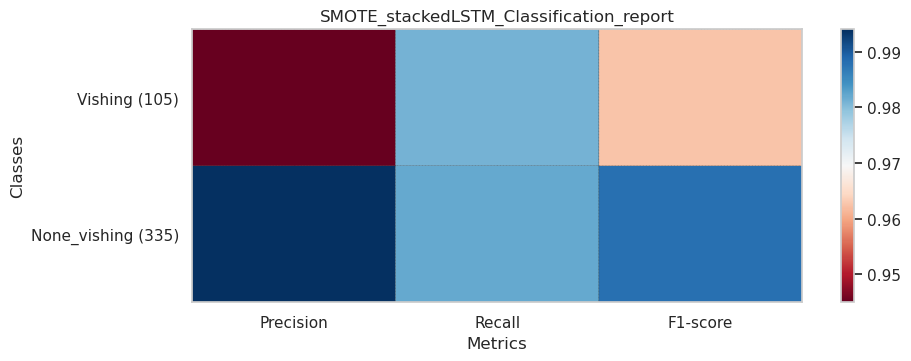

In [37]:
plot_name = over_name + '_stackedLSTM_Classification_report'
plot_classification_report(report_stackedlstm, plot_name)

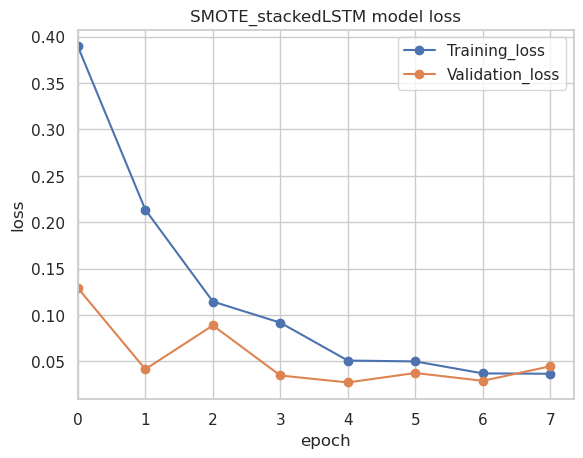

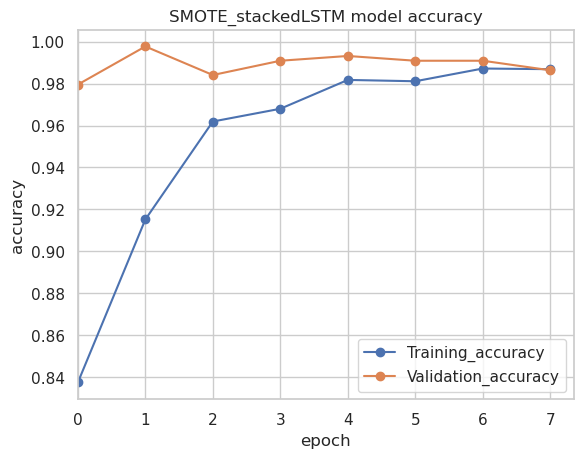

In [38]:
#plot the training and validation loss and accuracy
plot_name = over_name + '_stackedLSTM'
plot_loss_accuracy(history_stackedlstm, plot_name)

### Stacked LSTM layer with FastText embedding layer


In [39]:
# build, train and evaluate the stacked LSTM layers model with FastText embedding layer
model_name = over_name + '_stackedLSTM_FT'
model_stackedlstm_ft, history_stackedlstm_ft, report_stackedlstm_ft = build_train_stackedlstm_model(model_name, X_train_res, y_train_res, X_val_pad, y_val, X_test_pad, y_test, embedding_matrix=embedding_matrix)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 4715, 300)         10153200  
                                                                 
 lstm_4 (LSTM)               (None, 4715, 64)          93440     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10261233 (39.14 MB)
Trainable params: 10

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - 48s 457ms/step - loss: 0.4651 - accuracy: 0.7929 - val_loss: 0.2022 - val_accuracy: 0.9409
Epoch 2/10
98/98 [==============================] - ETA: 0s - loss: 0.3359 - accuracy: 0.8752
Epoch 2: val_accuracy did not improve from 0.94091
98/98 [==============================] - 46s 467ms/step - loss: 0.3359 - accuracy: 0.8752 - val_loss: 0.4776 - val_accuracy: 0.7886
Epoch 3/10
98/98 [==============================] - ETA: 0s - loss: 0.2399 - accuracy: 0.9069
Epoch 3: val_accuracy improved from 0.94091 to 0.97273, saving model to models/SMOTE_stackedLSTM_FT_20240215_132706.h5
98/98 [==============================] - 47s 477ms/step - loss: 0.2399 - accuracy: 0.9069 - val_loss: 0.1111 - val_accuracy: 0.9727
Epoch 4/10
98/98 [==============================] - ETA: 0s - loss: 0.4683 - accuracy: 0.7682
Epoch 4: val_accuracy did not improve from 0.97273
98/98 [==============================] - 49s 495ms/step - loss: 0.4683 - accuracy: 0.7682 - val_loss:

In [40]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
SMOTE_LSTM,0.967136,0.953704,0.980952,0.984091,224.577615
SMOTE_LSTM_FT,0.933333,0.875000,1.000000,0.965909,150.270501
SMOTE_stackedLSTM,0.962617,0.944954,0.980952,0.981818,373.197198
SMOTE_stackedLSTM_FT,0.904348,0.832000,0.990476,0.950000,279.043944


[0.9968, 0.9373, 0.9662]
[0.832, 0.9905, 0.9043]
plotMat: [[0.9968, 0.9373, 0.9662], [0.832, 0.9905, 0.9043]]
support: [335, 105]


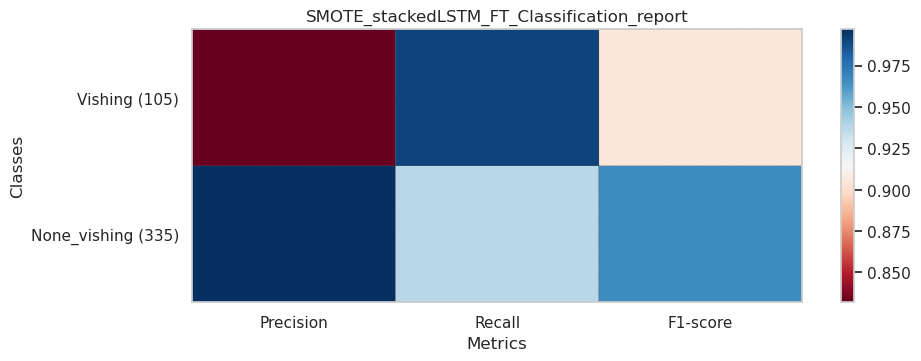

In [41]:
#plot the confusion matrix
plot_name = over_name + '_stackedLSTM_FT_Classification_report'
plot_classification_report(report_stackedlstm_ft, plot_name)

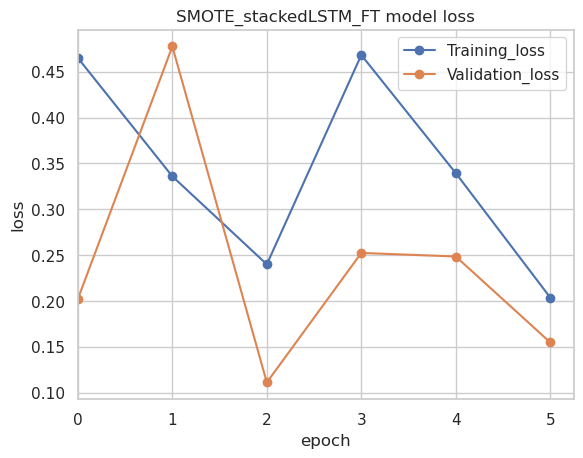

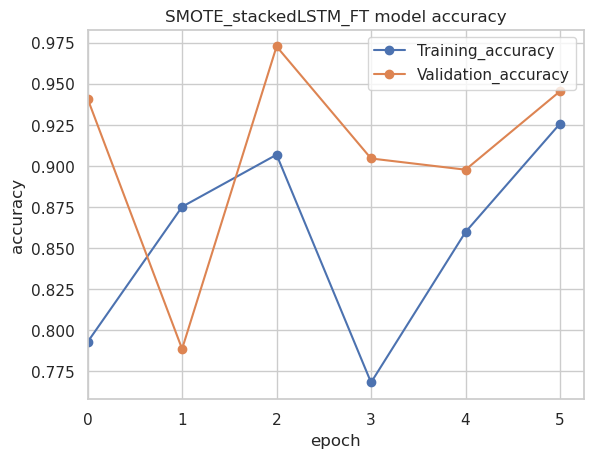

In [42]:
#plot the training and validation loss and accuracy
plot_name = over_name + '_stackedLSTM_FT'
plot_loss_accuracy(history_stackedlstm_ft, plot_name)

### Single BiLSTM layer

In [43]:
# Function to build, train and evaluate the BiLSTM model
def build_train_bilstm_model(model_name, X_train, y_train, X_val, y_val, X_test, y_test, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, embedding_matrix=None):
    
    # define the model architecture
    model = Sequential()
    # check if the embedding_matrix is None or not
    if embedding_matrix is None:
        model.add(Embedding(max_words, embedding_dim, input_length=max_len, trainable=False))
    else:
        model.add(Embedding(max_words, embedding_dim, weights= [embedding_matrix], input_length=max_len, trainable=False))
    
    # model.add(SpatialDropout1D(spa_dropout_ratio))
    model.add(Bidirectional(LSTM(lstm_units_1)))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification
    
    # compile the model
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate
    )
    
    model.compile(
        # optimizer=Adam(learning_rate=learning_rate, decay=learning_rate / decay_steps),
        optimizer = Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    # print the model summary
    print(model.summary())
    print('#' * 150)
    
    # Create a callback that saves the best model during validation
    model_checkpoint = ModelCheckpoint(
        "models/" + model_name + "_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        # "models/BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        monitor='val_accuracy', # val_loss or val_accuracy 
        verbose=1,
        save_best_only=True,
        mode='max' # max for val_accuracy, min for val_loss
    )
    # EarlyStopping to stop training when the validation loss has stopped improving
    early_stopping = EarlyStopping(
        monitor = 'val_loss',
        verbose = 1,
        patience = 3, # Number of epochs with no improvement after which training will be stopped.
        mode = 'min'
    )

    # TensorBoard for visualization
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # train the model
    start_time = time()
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=[model_checkpoint, early_stopping, tensorboard_callback]
    )
    end_time = time()
    training_time = end_time - start_time
    
    # print the training time
    print('Training time: {}'.format(training_time))
    
    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print('Test Loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(accuracy))
    
    # predict the test set
    # y_pred = model.predict(X_test)
    # y_pred = np.argmax(y_pred, axis=1)
    # y_test = np.argmax(y_test, axis=1)
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs >= 0.5).astype(int)  # Convert probabilities to binary (0 or 1)
    
    # print the precision, recall and f1-score
    model_precision = precision_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    model_f1_score = f1_score(y_test, y_pred)
    print('Precision: {}'.format(model_precision))
    print('Recall: {}'.format(model_recall))
    print('F1-score: {}'.format(model_f1_score))
        
    # print the classification report
    report = classification_report(y_test, y_pred, digits=4, target_names=['None_vishing', 'Vishing'])
    print(report)
    
    # print the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\n-- Confusion matrix --\n', cm)
    print('True Positives(TP) = ', cm[0,0])
    print('True Negatives(TN) = ', cm[1,1])
    print('False Positives(FP) = ', cm[0,1])
    print('False Negatives(FN) = ', cm[1,0])
    
    # save the previous confusion matrix in a file following the TP, TN, FP, FN order
    np.savetxt('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv', cm, delimiter=',', fmt='%d')
    
    # save the confusion matrix in a dataframe wih the following columns: TP, TN, FP, FN
    df_cm = pd.DataFrame(cm, columns=['None_vishing', 'Vishing'], index=['None_vishing', 'Vishing'])
    df_cm.to_csv('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv')
    
    # save the model
    # model.save('models/{}.h5'.format(model_name))
    
    # save the history
    with open('histories/{}.pkl'.format(model_name), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    # save the results
    df_results.loc[model_name] = [model_f1_score, model_precision, model_recall, accuracy, training_time]
    # df_results.loc[model_name] = [f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), accuracy, training_time]  
    
    # print the results
    # df_results
    
    return model, history, report

In [44]:
# build, train and evaluate the BiLSTM model
model_name = over_name + '_BiLSTM'
model_bilstm, history_bilstm, report_bilstm = build_train_bilstm_model(model_name, X_train_res, y_train_res, X_val_pad, y_val, X_test_pad, y_test)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 4715, 300)         10153200  
                                                                 
 bidirectional (Bidirection  (None, 128)               186880    
 al)                                                             
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10348401 (39.48 MB)
Trainable params: 195201 (762.50 KB)
Non-trainable params: 10153200 (38.73 MB)
_______

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - 52s 490ms/step - loss: 0.5332 - accuracy: 0.7634 - val_loss: 0.5014 - val_accuracy: 0.8568
Epoch 2/10
98/98 [==============================] - ETA: 0s - loss: 0.3187 - accuracy: 0.8972
Epoch 2: val_accuracy improved from 0.85682 to 0.98636, saving model to models/SMOTE_BiLSTM_20240215_133155.h5
98/98 [==============================] - 46s 473ms/step - loss: 0.3187 - accuracy: 0.8972 - val_loss: 0.1541 - val_accuracy: 0.9864
Epoch 3/10
98/98 [==============================] - ETA: 0s - loss: 0.3537 - accuracy: 0.8812
Epoch 3: val_accuracy did not improve from 0.98636
98/98 [==============================] - 45s 462ms/step - loss: 0.3537 - accuracy: 0.8812 - val_loss: 1.2309 - val_accuracy: 0.3114
Epoch 4/10
98/98 [==============================] - ETA: 0s - loss: 0.4390 - accuracy: 0.8556
Epoch 4: val_accuracy did not improve from 0.98636
98/98 [==============================] - 45s 461ms/step - loss: 0.4390 - accuracy: 0.8556 - val_loss: 4.5886 

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

In [45]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
SMOTE_LSTM,0.967136,0.953704,0.980952,0.984091,224.577615
SMOTE_LSTM_FT,0.933333,0.875000,1.000000,0.965909,150.270501
SMOTE_stackedLSTM,0.962617,0.944954,0.980952,0.981818,373.197198
SMOTE_stackedLSTM_FT,0.904348,0.832000,0.990476,0.950000,279.043944
SMOTE_BiLSTM,0.000000,0.000000,0.000000,0.761364,232.570004


[0.7614, 1.0, 0.8645]
[0.0, 0.0, 0.0]
plotMat: [[0.7614, 1.0, 0.8645], [0.0, 0.0, 0.0]]
support: [335, 105]


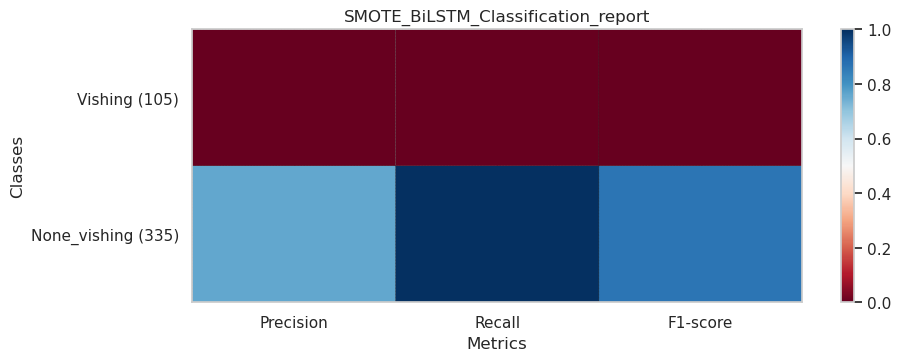

In [46]:
#plot the confusion matrix
plot_name = over_name + '_BiLSTM_Classification_report'
plot_classification_report(report_bilstm, plot_name)

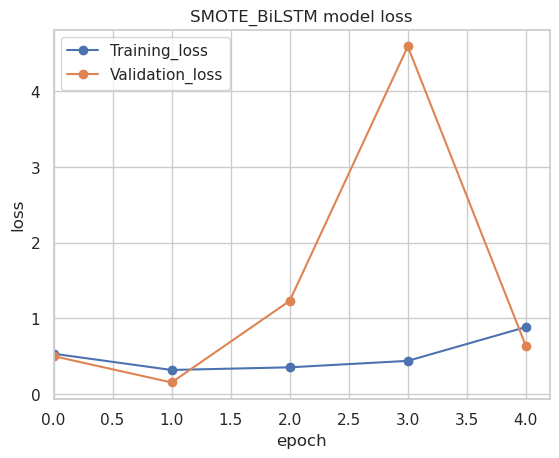

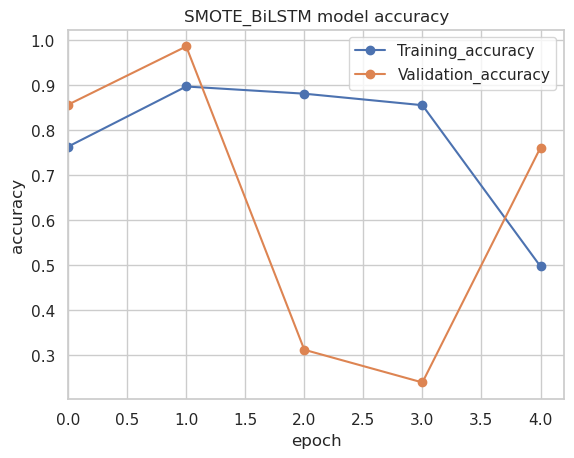

In [47]:
#plot the training and validation loss and accuracy
plot_name = over_name + '_BiLSTM'
plot_loss_accuracy(history_bilstm, plot_name)

### Single BiLSTM layer with FastText embedding layer

In [48]:
# build, train and evaluate the BiLSTM model with FastText embedding layer
model_name = over_name + '_BiLSTM_FT'
model_bilstm_ft, history_bilstm_ft, report_bilstm_ft = build_train_bilstm_model(model_name, X_train_res, y_train_res, X_val_pad, y_val, X_test_pad, y_test, embedding_matrix=embedding_matrix)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 4715, 300)         10153200  
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               186880    
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10348401 (39.48 MB)
Trainable params: 195201 (762.50 KB)
Non-trainable params: 10153200 (38.73 MB)
_______

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - 55s 528ms/step - loss: 0.4868 - accuracy: 0.7724 - val_loss: 0.2990 - val_accuracy: 0.8773
Epoch 2/10
98/98 [==============================] - ETA: 0s - loss: 0.2931 - accuracy: 0.8771
Epoch 2: val_accuracy did not improve from 0.87727
98/98 [==============================] - 46s 472ms/step - loss: 0.2931 - accuracy: 0.8771 - val_loss: 0.5340 - val_accuracy: 0.7500
Epoch 3/10
98/98 [==============================] - ETA: 0s - loss: 0.3231 - accuracy: 0.8633
Epoch 3: val_accuracy improved from 0.87727 to 0.95000, saving model to models/SMOTE_BiLSTM_FT_20240215_133558.h5
98/98 [==============================] - 49s 500ms/step - loss: 0.3231 - accuracy: 0.8633 - val_loss: 0.1592 - val_accuracy: 0.9500
Epoch 4/10
98/98 [==============================] - ETA: 0s - loss: 0.2083 - accuracy: 0.9209
Epoch 4: val_accuracy did not improve from 0.95000
98/98 [==============================] - 44s 454ms/step - loss: 0.2083 - accuracy: 0.9209 - val_loss: 0.36

In [49]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
SMOTE_LSTM,0.967136,0.953704,0.980952,0.984091,224.577615
SMOTE_LSTM_FT,0.933333,0.875000,1.000000,0.965909,150.270501
SMOTE_stackedLSTM,0.962617,0.944954,0.980952,0.981818,373.197198
SMOTE_stackedLSTM_FT,0.904348,0.832000,0.990476,0.950000,279.043944
SMOTE_BiLSTM,0.000000,0.000000,0.000000,0.761364,232.570004
SMOTE_BiLSTM_FT,0.962617,0.944954,0.980952,0.981818,394.456028


[0.994, 0.9821, 0.988]
[0.945, 0.981, 0.9626]
plotMat: [[0.994, 0.9821, 0.988], [0.945, 0.981, 0.9626]]
support: [335, 105]


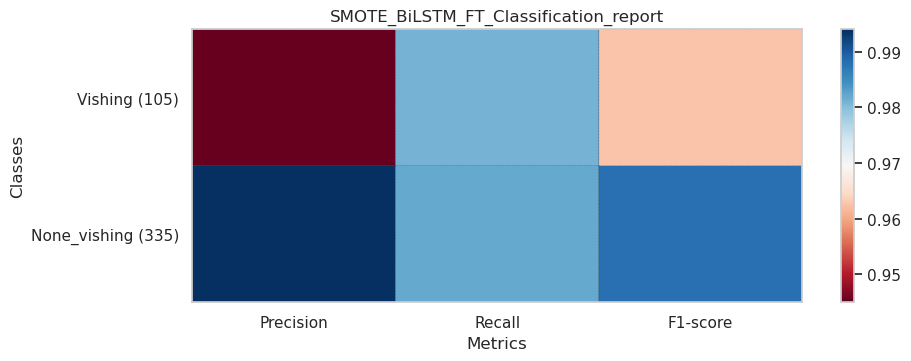

In [50]:
#plot the confusion matrix
plot_name = over_name + '_BiLSTM_FT_Classification_report'
plot_classification_report(report_bilstm_ft, plot_name)

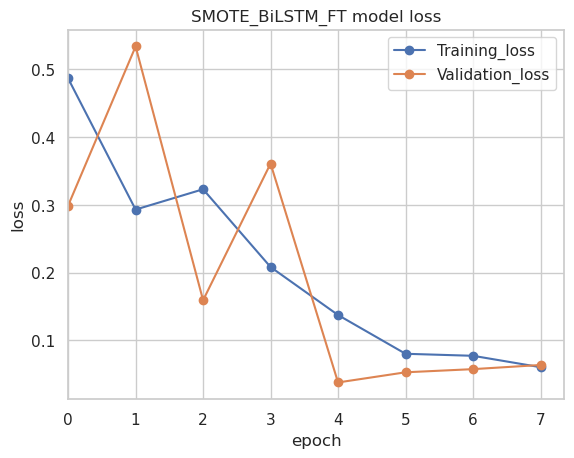

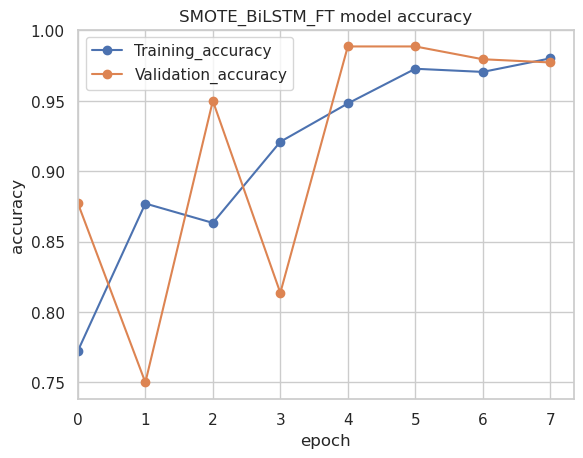

In [51]:
#plot the training and validation loss and accuracy
plot_name = over_name + '_BiLSTM_FT'
plot_loss_accuracy(history_bilstm_ft, plot_name)

### Stacked BiLSTM layers

In [52]:
# Function to build, train and evaluate the stacked BiLSTM model
def build_train_stackedbilstm_model(model_name, X_train, y_train, X_val, y_val, X_test, y_test, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, embedding_matrix=None):
    
    # define the model architecture
    model = Sequential()
    # check if the embedding_matrix is None or not
    if embedding_matrix is None:
        model.add(Embedding(max_words, embedding_dim, input_length=max_len, trainable=False))
    else:
        model.add(Embedding(max_words, embedding_dim, weights= [embedding_matrix], input_length=max_len, trainable=False))
    
    # model.add(SpatialDropout1D(spa_dropout_ratio))
    model.add(Bidirectional(LSTM(lstm_units_1,return_sequences=True)))
    model.add(Bidirectional(LSTM(lstm_units_2)))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification
    
    # compile the model
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate
    )
    
    model.compile(
        # optimizer=Adam(learning_rate=learning_rate, decay=learning_rate / decay_steps),
        optimizer = Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    # print the model summary
    print(model.summary())
    print('#' * 150)
    
    # Create a callback that saves the best model during validation
    model_checkpoint = ModelCheckpoint(
        "models/" + model_name + "_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        # "models/BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        monitor='val_accuracy', # val_loss or val_accuracy 
        verbose=1,
        save_best_only=True,
        mode='max' # max for val_accuracy, min for val_loss
    )
    # EarlyStopping to stop training when the validation loss has stopped improving
    early_stopping = EarlyStopping(
        monitor = 'val_loss',
        verbose = 1,
        patience = 3, # Number of epochs with no improvement after which training will be stopped.
        mode = 'min'
    )

    # TensorBoard for visualization
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # train the model
    start_time = time()
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=[model_checkpoint, early_stopping, tensorboard_callback]
    )
    end_time = time()
    training_time = end_time - start_time
    
    # print the training time
    print('Training time: {}'.format(training_time))
    
    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print('Test Loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(accuracy))
    
    # predict the test set
    # y_pred = model.predict(X_test)
    # y_pred = np.argmax(y_pred, axis=1)
    # y_test = np.argmax(y_test, axis=1)
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs >= 0.5).astype(int)  # Convert probabilities to binary (0 or 1)
    
    # print the precision, recall and f1-score
    model_precision = precision_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    model_f1_score = f1_score(y_test, y_pred)
    print('Precision: {}'.format(model_precision))
    print('Recall: {}'.format(model_recall))
    print('F1-score: {}'.format(model_f1_score))
        
    # print the classification report
    report = classification_report(y_test, y_pred, digits=4, target_names=['None_vishing', 'Vishing'])
    print(report)
    
    # print the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\n-- Confusion matrix --\n', cm)
    print('True Positives(TP) = ', cm[0,0])
    print('True Negatives(TN) = ', cm[1,1])
    print('False Positives(FP) = ', cm[0,1])
    print('False Negatives(FN) = ', cm[1,0])
    
    # save the previous confusion matrix in a file following the TP, TN, FP, FN order
    np.savetxt('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv', cm, delimiter=',', fmt='%d')
    
    # save the confusion matrix in a dataframe wih the following columns: TP, TN, FP, FN
    df_cm = pd.DataFrame(cm, columns=['None_vishing', 'Vishing'], index=['None_vishing', 'Vishing'])
    df_cm.to_csv('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv')
    
    # save the model
    # model.save('models/{}.h5'.format(model_name))
    
    # save the history
    with open('histories/{}.pkl'.format(model_name), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    # save the results
    df_results.loc[model_name] = [model_f1_score, model_precision, model_recall, accuracy, training_time]
    # df_results.loc[model_name] = [f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), accuracy, training_time]  
    
    # print the results
    # df_results
    
    return model, history, report

In [53]:
# build, train and evaluate the stacked BiLSTM model
model_name = over_name + '_stackedBiLSTM'
model_stackedbilstm, history_stackedbilstm, report_stackedbilstm = build_train_stackedbilstm_model(model_name, X_train_res, y_train_res, X_val_pad, y_val, X_test_pad, y_test)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 4715, 300)         10153200  
                                                                 
 bidirectional_2 (Bidirecti  (None, 4715, 128)         186880    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - 103s 1s/step - loss: 0.6925 - accuracy: 0.5535 - val_loss: 0.3653 - val_accuracy: 0.9545
Epoch 2/10
98/98 [==============================] - ETA: 0s - loss: 0.5438 - accuracy: 0.7401
Epoch 2: val_accuracy did not improve from 0.95455
98/98 [==============================] - 97s 982ms/step - loss: 0.5438 - accuracy: 0.7401 - val_loss: 0.1817 - val_accuracy: 0.9341
Epoch 3/10
98/98 [==============================] - ETA: 0s - loss: 0.2279 - accuracy: 0.9309
Epoch 3: val_accuracy improved from 0.95455 to 0.97500, saving model to models/SMOTE_stackedBiLSTM_20240215_134241.h5
98/98 [==============================] - 89s 913ms/step - loss: 0.2279 - accuracy: 0.9309 - val_loss: 0.0986 - val_accuracy: 0.9750
Epoch 4/10
98/98 [==============================] - ETA: 0s - loss: 0.1604 - accuracy: 0.9385
Epoch 4: val_accuracy improved from 0.97500 to 0.99091, saving model to models/SMOTE_stackedBiLSTM_20240215_134241.h5
98/98 [==============================

In [54]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
SMOTE_LSTM,0.967136,0.953704,0.980952,0.984091,224.577615
SMOTE_LSTM_FT,0.933333,0.875000,1.000000,0.965909,150.270501
SMOTE_stackedLSTM,0.962617,0.944954,0.980952,0.981818,373.197198
SMOTE_stackedLSTM_FT,0.904348,0.832000,0.990476,0.950000,279.043944
SMOTE_BiLSTM,0.000000,0.000000,0.000000,0.761364,232.570004
SMOTE_BiLSTM_FT,0.962617,0.944954,0.980952,0.981818,394.456028
SMOTE_stackedBiLSTM,0.909910,0.863248,0.961905,0.954545,945.877354


[0.9876, 0.9522, 0.9696]
[0.8632, 0.9619, 0.9099]
plotMat: [[0.9876, 0.9522, 0.9696], [0.8632, 0.9619, 0.9099]]
support: [335, 105]


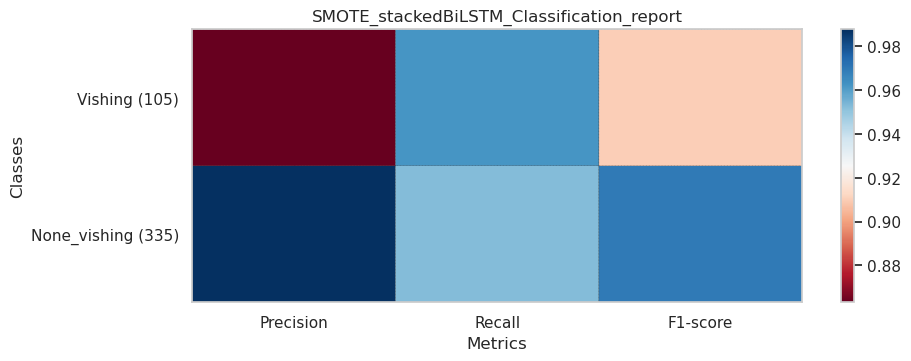

In [55]:
#plot the confusion matrix
plot_name = over_name + '_stackedBiLSTM_Classification_report'
plot_classification_report(report_stackedbilstm, plot_name)

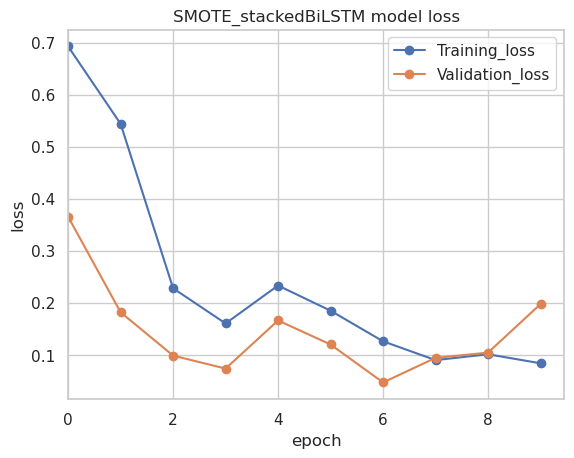

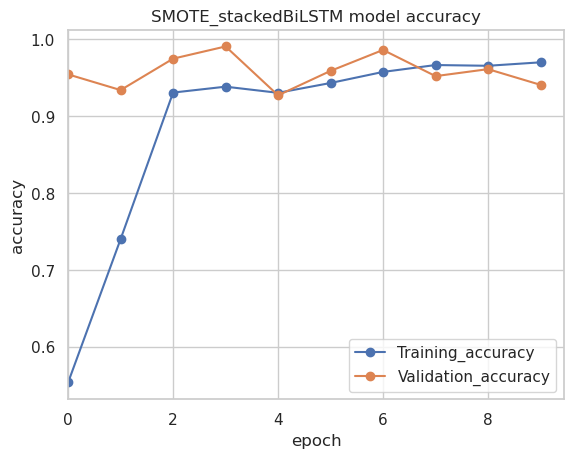

In [56]:
#plot the training and validation loss and accuracy
plot_name = over_name + '_stackedBiLSTM'
plot_loss_accuracy(history_stackedbilstm, plot_name)

### Stacked BiLSTM layer with FastText embedding layer with FastText embedding layer

In [57]:
# build, train and evaluate the stacked BiLSTM model with FastText embedding layer
model_name = over_name + '_stackedBiLSTM_FT'
model_stackedbilstm_ft, history_stackedbilstm_ft, report_stackedbilstm_ft = build_train_stackedbilstm_model(model_name, X_train_res, y_train_res, X_val_pad, y_val, X_test_pad, y_test, embedding_matrix=embedding_matrix)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 4715, 300)         10153200  
                                                                 
 bidirectional_4 (Bidirecti  (None, 4715, 128)         186880    
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - 105s 1s/step - loss: 0.4497 - accuracy: 0.7913 - val_loss: 0.1743 - val_accuracy: 0.9545
Epoch 2/10
98/98 [==============================] - ETA: 0s - loss: 0.3025 - accuracy: 0.8806
Epoch 2: val_accuracy did not improve from 0.95455
98/98 [==============================] - 93s 951ms/step - loss: 0.3025 - accuracy: 0.8806 - val_loss: 0.1943 - val_accuracy: 0.9455
Epoch 3/10
98/98 [==============================] - ETA: 0s - loss: 0.3817 - accuracy: 0.8444
Epoch 3: val_accuracy did not improve from 0.95455
98/98 [==============================] - 90s 918ms/step - loss: 0.3817 - accuracy: 0.8444 - val_loss: 0.1709 - val_accuracy: 0.9523
Epoch 4/10
98/98 [==============================] - ETA: 0s - loss: 0.2350 - accuracy: 0.9104
Epoch 4: val_accuracy improved from 0.95455 to 0.96818, saving model to models/SMOTE_stackedBiLSTM_FT_20240215_135845.h5
98/98 [==============================] - 100s 1s/step - loss: 0.2350 - accuracy: 0.9104 - val_loss: 0

In [58]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
SMOTE_LSTM,0.967136,0.953704,0.980952,0.984091,224.577615
SMOTE_LSTM_FT,0.933333,0.875000,1.000000,0.965909,150.270501
SMOTE_stackedLSTM,0.962617,0.944954,0.980952,0.981818,373.197198
SMOTE_stackedLSTM_FT,0.904348,0.832000,0.990476,0.950000,279.043944
SMOTE_BiLSTM,0.000000,0.000000,0.000000,0.761364,232.570004
SMOTE_BiLSTM_FT,0.962617,0.944954,0.980952,0.981818,394.456028
SMOTE_stackedBiLSTM,0.909910,0.863248,0.961905,0.954545,945.877354
SMOTE_stackedBiLSTM_FT,0.985507,1.000000,0.971429,0.993182,943.014318


[0.9911, 1.0, 0.9955]
[1.0, 0.9714, 0.9855]
plotMat: [[0.9911, 1.0, 0.9955], [1.0, 0.9714, 0.9855]]
support: [335, 105]


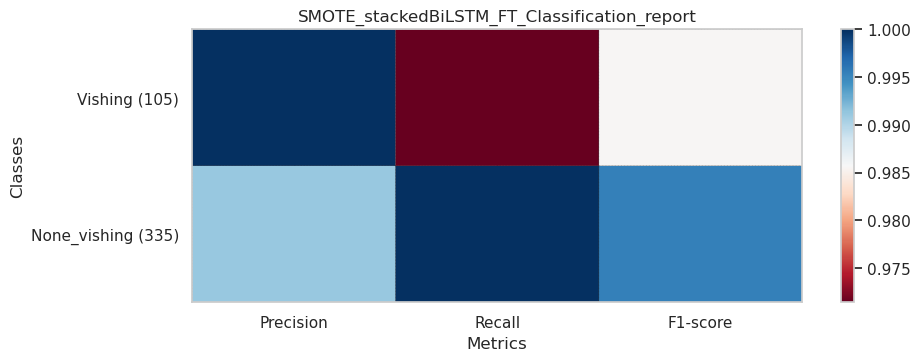

In [59]:
#plot the confusion matrix
plot_name = over_name + '_stackedBiLSTM_FT_Classification_report'
plot_classification_report(report_stackedbilstm_ft, plot_name)

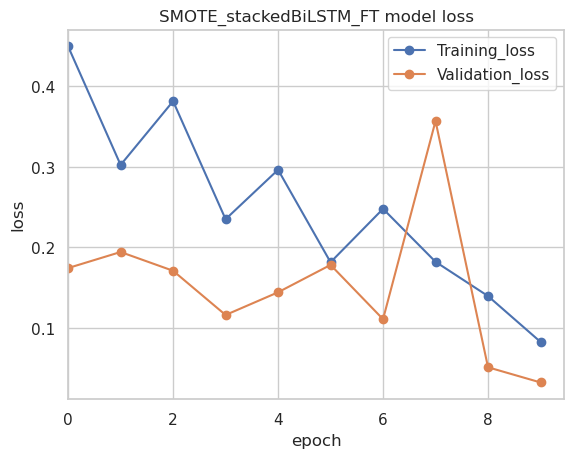

In [ ]:
#plot the training and validation loss and accuracy
plot_name = over_name + '_stackedBiLSTM_FT'
plot_loss_accuracy(history_stackedbilstm_ft, plot_name)

### 1D CNN Layer

In [ ]:
# Function to build, train and evaluate the stacked BiLSTM model
def build_train_cnn_model(model_name, X_train, y_train, X_val, y_val, X_test, y_test, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, embedding_matrix=None):
    
    # define the model architecture
    model = Sequential()
    # check if the embedding_matrix is None or not
    if embedding_matrix is None:
        model.add(Embedding(max_words, embedding_dim, input_length=max_len, trainable=False))
    else:
        model.add(Embedding(max_words, embedding_dim, weights= [embedding_matrix], input_length=max_len, trainable=False))

    # model.add(SpatialDropout1D(spa_dropout_ratio))
    model.add(Conv1D(num_filters, kernel_size, activation='relu', padding='valid'))
    model.add(MaxPooling1D())
    # model.add(GlobalMaxPooling1D()) #takes the maximum value over the time dimension from each feature map generated by the convolutional layers, Dimensionality Reduction, Reduces Overfitting
    model.add(Dense(dense_units, activation='relu'))
    model.add(Flatten()) # no need if used Global poooling
    model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification
    
    # compile the model
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate
    )
    
    model.compile(
        # optimizer=Adam(learning_rate=learning_rate, decay=learning_rate / decay_steps),
        optimizer = Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    # print the model summary
    print(model.summary())
    print('#' * 150)
    
    # Create a callback that saves the best model during validation
    model_checkpoint = ModelCheckpoint(
        "models/" + model_name + "_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        # "models/BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        monitor='val_accuracy', # val_loss or val_accuracy 
        verbose=1,
        save_best_only=True,
        mode='max' # max for val_accuracy, min for val_lossmode='mn'
    )
    # EarlyStopping to stop training when the validation loss has stopped improving
    early_stopping = EarlyStopping(
        monitor = 'val_loss',
        verbose = 1,
        patience = 3, # Number of epochs with no improvement after which training will be stopped.
        mode = 'min'
    )

    # TensorBoard for visualization
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # train the model
    start_time = time()
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=[model_checkpoint, early_stopping, tensorboard_callback]
    )
    end_time = time()
    training_time = end_time - start_time
    
    # print the training time
    print('Training time: {}'.format(training_time))
    
    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print('Test Loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(accuracy))
    
    # predict the test set
    # y_pred = model.predict(X_test)
    # y_pred = np.argmax(y_pred, axis=1)
    # y_test = np.argmax(y_test, axis=1)
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs >= 0.5).astype(int)  # Convert probabilities to binary (0 or 1)
    
    # print the precision, recall and f1-score
    model_precision = precision_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    model_f1_score = f1_score(y_test, y_pred)
    print('Precision: {}'.format(model_precision))
    print('Recall: {}'.format(model_recall))
    print('F1-score: {}'.format(model_f1_score))
        
    # print the classification report
    report = classification_report(y_test, y_pred, digits=4, target_names=['None_vishing', 'Vishing'])
    print(report)
    
    # print the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\n-- Confusion matrix --\n', cm)
    print('True Positives(TP) = ', cm[0,0])
    print('True Negatives(TN) = ', cm[1,1])
    print('False Positives(FP) = ', cm[0,1])
    print('False Negatives(FN) = ', cm[1,0])
    
    # save the previous confusion matrix in a file following the TP, TN, FP, FN order
    np.savetxt('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv', cm, delimiter=',', fmt='%d')
    
    # save the confusion matrix in a dataframe wih the following columns: TP, TN, FP, FN
    df_cm = pd.DataFrame(cm, columns=['None_vishing', 'Vishing'], index=['None_vishing', 'Vishing'])
    df_cm.to_csv('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv')
    
    # save the model
    # model.save('models/{}.h5'.format(model_name))
    
    # save the history
    with open('histories/{}.pkl'.format(model_name), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    # save the results
    df_results.loc[model_name] = [model_f1_score, model_precision, model_recall, accuracy, training_time]
    # df_results.loc[model_name] = [f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), accuracy, training_time]  
    
    # print the results
    # df_results
    
    return model, history, report

In [ ]:
# build, train and evaluate the CNN model
model_name = over_name + '_CNN'
model_cnn, history_cnn, report_cnn = build_train_cnn_model(model_name, X_train_res, y_train_res, X_val_pad, y_val, X_test_pad, y_test)

In [ ]:
# print the results
df_results

In [ ]:
#plot the confusion matrix
plot_name = over_name + '_CNN_Classification_report'
plot_classification_report(report_cnn, plot_name)

In [ ]:
#plot the training and validation loss and accuracy
plot_name = over_name + '_CNN'
plot_loss_accuracy(history_cnn, plot_name)

#### 1D CNN layer with FastText embedding layer

In [ ]:
# build, train and evaluate the CNN model with FastText embedding layer
model_name = over_name + '_CNN_FT'
model_cnn_ft, history_cnn_ft, report_cnn_ft = build_train_cnn_model(model_name, X_train_res, y_train_res, X_val_pad, y_val, X_test_pad, y_test, embedding_matrix=embedding_matrix)

In [ ]:
# print the results
df_results

In [ ]:
#plot the confusion matrix
plot_name = over_name + '_CNN_FT_Classification_report'
plot_classification_report(report_cnn_ft, plot_name)

In [ ]:
#plot the training and validation loss and accuracy
plot_name = over_name + '_CNN_FT'
plot_loss_accuracy(history_cnn_ft, plot_name)

### 1D CNN layer with multiple kernel sizes

In [ ]:
# Function to build, train and evaluate the 1D CNN layer with multiple kernel sizes model
def build_train_cnn_multiple_model(model_name, X_train, y_train, X_val, y_val, X_test, y_test, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, embedding_matrix=None):
    
    # define the model architecture
    model = Sequential()
    # check if the embedding_matrix is None or not
    if embedding_matrix is None:
        model.add(Embedding(max_words, embedding_dim, input_length=max_len, trainable=False))
    else:
        model.add(Embedding(max_words, embedding_dim, weights= [embedding_matrix], input_length=max_len, trainable=False))

    # model.add(SpatialDropout1D(spa_dropout_ratio))
    model.add(Conv1D(num_filters, kernel_size, activation='relu', padding='same'))
    model.add(MaxPooling1D())
    model.add(Conv1D(num_filters, kernel_size+1, activation='relu', padding='same'))
    model.add(MaxPooling1D())
    model.add(Conv1D(num_filters, kernel_size+2, activation='relu', padding='same'))
    model.add(MaxPooling1D())
    # model.add(GlobalMaxPooling1D()) #takes the maximum value over the time dimension from each feature map generated by the convolutional layers, Dimensionality Reduction, Reduces Overfitting
    model.add(Dense(dense_units, activation='relu'))
    model.add(Flatten()) # no need if used Global poooling
    model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

    # compile the model
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate
    )

    model.compile(
        # optimizer=Adam(learning_rate=learning_rate, decay=learning_rate / decay_steps),
        optimizer=Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # print the model summary
    print(model.summary())
    print('#' * 150)

    # Create a callback that saves the best model during validation
    model_checkpoint = ModelCheckpoint(
        "models/" + model_name + "_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        # "models/BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        monitor='val_accuracy',  # val_loss or val_accuracy 
        verbose=1,
        save_best_only=True,
        mode='max'  # max for val_accuracy, min for val_lossmode='mn'
    )
    # EarlyStopping to stop training when the validation loss has stopped improving
    early_stopping = EarlyStopping(
        monitor='val_loss',
        verbose=1,
        patience=3,  # Number of epochs with no improvement after which training will be stopped.
        mode='min'
    )

    # TensorBoard for visualization
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # train the model
    start_time = time()
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=[model_checkpoint, early_stopping, tensorboard_callback]
    )
    end_time = time()
    training_time = end_time - start_time

    # print the training time
    print('Training time: {}'.format(training_time))

    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print('Test Loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(accuracy))

    # predict the test set
    # y_pred = model.predict(X_test)
    # y_pred = np.argmax(y_pred, axis=1)
    # y_test = np.argmax(y_test, axis=1)
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs >= 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

    # print the precision, recall and f1-score
    model_precision = precision_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    model_f1_score = f1_score(y_test, y_pred)
    print('Precision: {}'.format(model_precision))
    print('Recall: {}'.format(model_recall))
    print('F1-score: {}'.format(model_f1_score))

    # print the classification report
    report = classification_report(y_test, y_pred, digits=4, target_names=['None_vishing', 'Vishing'])
    print(report)

    # print the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\n-- Confusion matrix --\n', cm)
    print('True Positives(TP) = ', cm[0,0])
    print('True Negatives(TN) = ', cm[1,1])
    print('False Positives(FP) = ', cm[0,1])
    print('False Negatives(FN) = ', cm[1,0])
    
    # save the previous confusion matrix in a file following the TP, TN, FP, FN order
    np.savetxt('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv', cm, delimiter=',', fmt='%d')
    
    # save the confusion matrix in a dataframe wih the following columns: TP, TN, FP, FN
    df_cm = pd.DataFrame(cm, columns=['None_vishing', 'Vishing'], index=['None_vishing', 'Vishing'])
    df_cm.to_csv('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv')
    
    # save the model
    # model.save('models/{}.h5'.format(model_name))

    # save the history
    with open('histories/{}.pkl'.format(model_name), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

    # save the results
    df_results.loc[model_name] = [model_f1_score, model_precision, model_recall, accuracy, training_time]
    # df_results.loc[model_name] = [f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), accuracy, training_time]  

    # print the results
    # df_results

    return model, history, report

In [ ]:
# build, train and evaluate the CNN with mulitple kernel sizes model
model_name = over_name + '_CNN_multiple'
model_cnn_multiple, history_cnn_multiple, report_cnn_multiple = build_train_cnn_multiple_model(model_name, X_train_res, y_train_res, X_val_pad, y_val, X_test_pad, y_test)

In [ ]:
# print the results
df_results

In [ ]:
#plot the confusion matrix
plot_name = over_name + '_CNN_multiple_Classification_report'
plot_classification_report(report_cnn_multiple, plot_name)

In [ ]:
#plot the training and validation loss and accuracy
plot_name = over_name + '_CNN_multiple'
plot_loss_accuracy(history_cnn_multiple, plot_name)

#### 1D CNN layer with multiple kernel sizes with FastText embedding layer

In [75]:
# build, train and evaluate the CNN with multiple kernel sizes model with FastText embedding layer
model_name = over_name + '_CNN_multiple_FT'
model_cnn_multiple_ft, history_cnn_multiple_ft, report_cnn_multiple_ft = build_train_cnn_multiple_model(model_name, X_train_res, y_train_res, X_val_pad, y_val, X_test_pad, y_test, embedding_matrix=embedding_matrix)

95/98 [============================>.] - ETA: 0s - loss: 0.0247 - accuracy: 0.9911
Epoch 6: val_accuracy did not improve from 0.99545
98/98 [==============================] - 3s 26ms/step - loss: 0.0248 - accuracy: 0.9910 - val_loss: 0.0274 - val_accuracy: 0.9932
Epoch 7/10
96/98 [============================>.] - ETA: 0s - loss: 0.0095 - accuracy: 0.9964
Epoch 7: val_accuracy did not improve from 0.99545
98/98 [==============================] - 2s 23ms/step - loss: 0.0093 - accuracy: 0.9965 - val_loss: 0.0191 - val_accuracy: 0.9932
Epoch 7: early stopping
Training time: 20.277757167816162
14/14 [==============================] - 0s 8ms/step - loss: 0.0095 - accuracy: 0.9977
Test Loss: 0.00947375874966383
Test Accuracy: 0.9977272748947144
14/14 [==============================] - 0s 8ms/step
Precision: 0.9905660377358491
Recall: 1.0
F1-score: 0.9952606635071091
              precision    recall  f1-score   support

None_vishing     1.0000    0.9970    0.9985       335
     Vishing     0

In [76]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
SMOTE_LSTM,0.967136,0.953704,0.980952,0.984091,224.577615
SMOTE_LSTM_FT,0.933333,0.875000,1.000000,0.965909,150.270501
SMOTE_stackedLSTM,0.962617,0.944954,0.980952,0.981818,373.197198
SMOTE_stackedLSTM_FT,0.904348,0.832000,0.990476,0.950000,279.043944
SMOTE_BiLSTM,0.000000,0.000000,0.000000,0.761364,232.570004
SMOTE_BiLSTM_FT,0.962617,0.944954,0.980952,0.981818,394.456028
SMOTE_stackedBiLSTM,0.909910,0.863248,0.961905,0.954545,945.877354
SMOTE_stackedBiLSTM_FT,0.985507,1.000000,0.971429,0.993182,943.014318
SMOTE_CNN,0.995261,0.990566,1.000000,0.997727,27.654009
SMOTE_CNN_FT,0.995215,1.000000,0.990476,0.997727,22.456585


[1.0, 0.997, 0.9985]
[0.9906, 1.0, 0.9953]
plotMat: [[1.0, 0.997, 0.9985], [0.9906, 1.0, 0.9953]]
support: [335, 105]


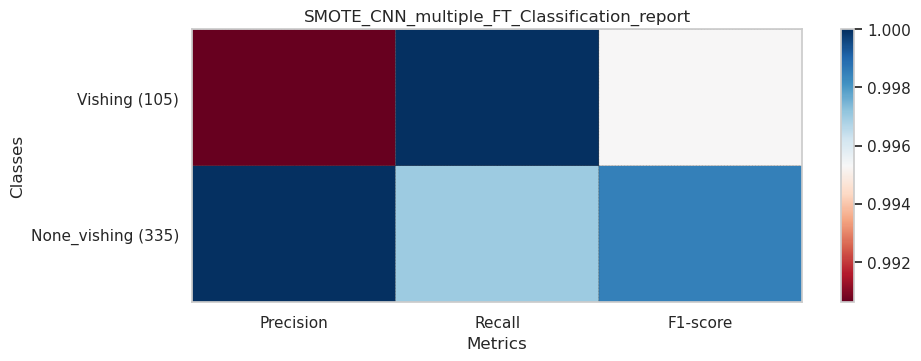

In [77]:
#plot the confusion matrix
plot_name = over_name + '_CNN_multiple_FT_Classification_report'
plot_classification_report(report_cnn_multiple_ft, plot_name)

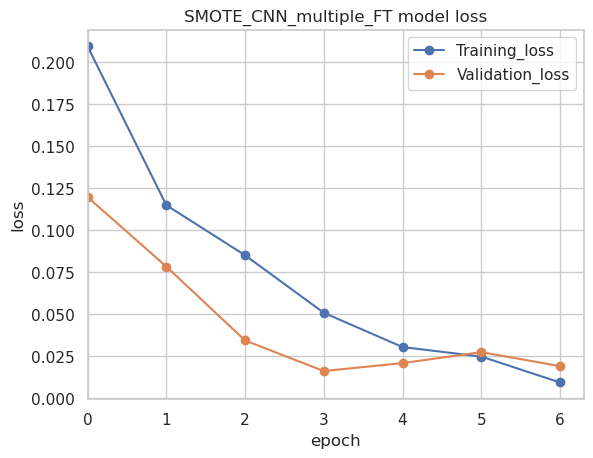

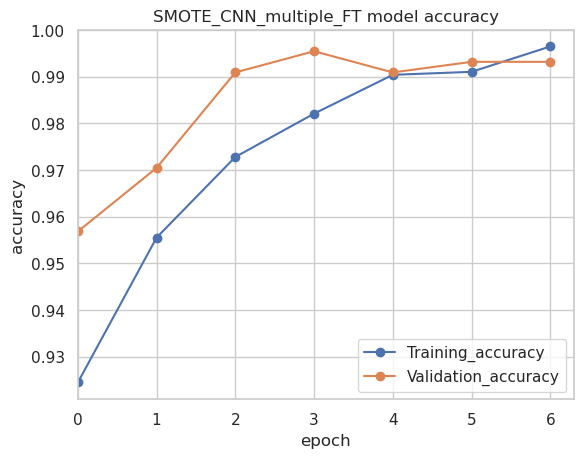

In [78]:
#plot the training and validation loss and accuracy
plot_name = over_name + '_CNN_multiple_FT'
plot_loss_accuracy(history_cnn_multiple_ft, plot_name)

## save the results in csv

In [79]:
# save the training results
df_results.to_csv("reports/" + over_name+ " _Models_performance_summary_" + datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".csv")

## Plot all the models performance


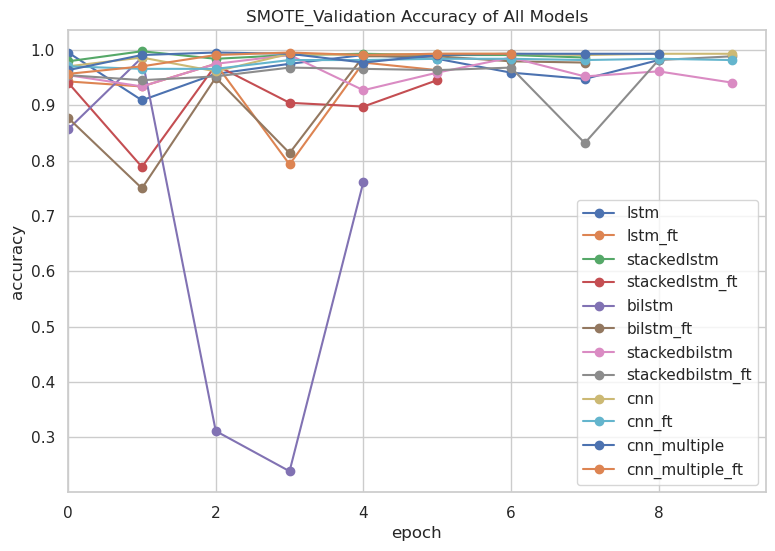

In [80]:
# plot overall accuracy on test set
fig = plt.figure(figsize=(9,6))
plt.plot(history_lstm.epoch, history_lstm.history['val_accuracy'], '-o', label='lstm')
plt.plot(history_lstm_ft.epoch, history_lstm_ft.history['val_accuracy'], '-o', label='lstm_ft')
plt.plot(history_stackedlstm.epoch, history_stackedlstm.history['val_accuracy'], '-o', label='stackedlstm')
plt.plot(history_stackedlstm_ft.epoch, history_stackedlstm_ft.history['val_accuracy'], '-o', label='stackedlstm_ft')
plt.plot(history_bilstm.epoch, history_bilstm.history['val_accuracy'], '-o', label='bilstm')
plt.plot(history_bilstm_ft.epoch, history_bilstm_ft.history['val_accuracy'], '-o', label='bilstm_ft')
plt.plot(history_stackedbilstm.epoch, history_stackedbilstm.history['val_accuracy'], '-o', label='stackedbilstm')
plt.plot(history_stackedbilstm_ft.epoch, history_stackedbilstm_ft.history['val_accuracy'], '-o', label='stackedbilstm_ft')
plt.plot(history_cnn.epoch, history_cnn.history['val_accuracy'], '-o', label='cnn')
plt.plot(history_cnn_ft.epoch,history_cnn_ft.history['val_accuracy'], '-o', label='cnn_ft')
plt.plot(history_cnn_multiple.epoch, history_cnn_multiple.history['val_accuracy'], '-o', label='cnn_multiple')
plt.plot(history_cnn_multiple_ft.epoch, history_cnn_multiple_ft.history['val_accuracy'], '-o', label='cnn_multiple_ft')
plt.title(over_name+'_Validation Accuracy of All Models')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig('reports/'+over_name+'_All_models_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
plt.savefig('reports/'+over_name+'_All_models_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

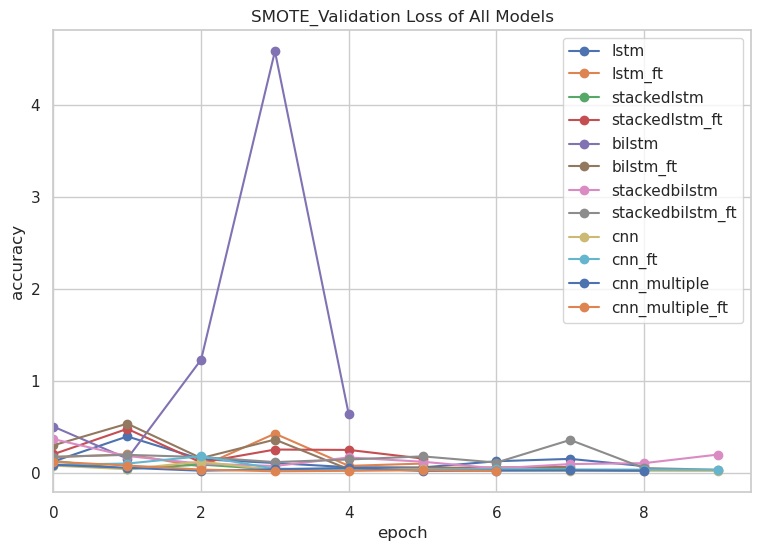

In [81]:
# plot overall looss on test set
fig = plt.figure(figsize=(9,6))
plt.plot(history_lstm.epoch, history_lstm.history['val_loss'], '-o', label='lstm')
plt.plot(history_lstm_ft.epoch, history_lstm_ft.history['val_loss'], '-o', label='lstm_ft')
plt.plot(history_stackedlstm.epoch, history_stackedlstm.history['val_loss'], '-o', label='stackedlstm')
plt.plot(history_stackedlstm_ft.epoch, history_stackedlstm_ft.history['val_loss'], '-o', label='stackedlstm_ft')
plt.plot(history_bilstm.epoch, history_bilstm.history['val_loss'], '-o', label='bilstm')
plt.plot(history_bilstm_ft.epoch, history_bilstm_ft.history['val_loss'], '-o', label='bilstm_ft')
plt.plot(history_stackedbilstm.epoch, history_stackedbilstm.history['val_loss'], '-o', label='stackedbilstm')
plt.plot(history_stackedbilstm_ft.epoch, history_stackedbilstm_ft.history['val_loss'], '-o', label='stackedbilstm_ft')
plt.plot(history_cnn.epoch, history_cnn.history['val_loss'], '-o', label='cnn')
plt.plot(history_cnn_ft.epoch, history_cnn_ft.history['val_loss'], '-o', label='cnn_ft')
plt.plot(history_cnn_multiple.epoch, history_cnn_multiple.history['val_loss'], '-o', label='cnn_multiple')
plt.plot(history_cnn_multiple_ft.epoch, history_cnn_multiple_ft.history['val_loss'], '-o', label='cnn_multiple_ft')
plt.title(over_name+'_Validation Loss of All Models')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig('reports/'+over_name+'_All_models_val_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
plt.savefig('reports/'+over_name+'_All_models_val_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()